# CÓDIGOS DE REFERÊNCIA (REMOVER ANTES DA VERSÃO FINAL!!!)

## core.py

In [5]:
from typing import Callable, Optional, Sequence
import matplotlib.pyplot as plt

# Gostei muito da implementação dessas classes da lista 7 do professor então decidi implementar com pequenas modificações
class Domain:
    """
    Define o domínio no qual uma função real existe.
    """
    min = None
    max = None

    def __contains__(self, x):
        raise NotImplementedError
    
    def __repr__(self):
        raise NotImplementedError

    def __str__(self):
        return self.__repr__()
    
    def copy(self):
        raise NotImplementedError 


class Interval(Domain):
    """
    Define um intervalo de números reais.
    """
    def __init__(self, p1, p2):
        self.inff, self.supp = min(p1, p2), max(p1, p2)
    
    @property
    def min(self):
        return self.inff

    @property
    def max(self):
        return self.supp
    
    @property
    def size(self):
        return (self.max - self.min)
    
    @property
    def half(self):
        return (self.max + self.min)/2.0
    
    def __contains__(self, other):
        if isinstance(other, Interval):
            return other.min >= self.min and other.max <= self.max
        elif isinstance(other, (float, int)):
            return self.min <= other <= self.max
        elif isinstance(other, Sequence):
            for i in other:
                if not (self.min <= i <= self.max):
                    return False
            return True
        else:
            return False


    def __str__(self):
        return f'[{self.min:2.4f}, {self.max:2.4f}]' 

    def __repr__(self):
        return f'[{self.min!r:2.4f}, {self.max!r:2.4f}]'
    
    def copy(self):
        return Interval(self.min, self.max)

    def intersect(self, other: 'Interval') -> Optional['Interval']:
        if not isinstance(other, Interval):
            return None
        
        newMin = max(self.min, other.min)
        newMax = min(self.max, other.max)
        return Interval(newMin,newMax) if newMin <= newMax else None

class RealFunction:
    """
    Classe abstrata que deve ser utilizada para implementação de funções reais, e.g. Polinomios
    """

    f: Callable[[float], float]
    prime: Optional[Callable[[float], float]]
    domain: Optional[Interval]
    
    def eval_safe(self, x):
        if self.domain is None or x in self.domain:
            return self.f(x)
        else:
            raise Exception("The number is out of the domain")

    def prime_safe(self, x):
        if self.prime is None:
            raise NotImplementedError("Derivative function (prime) is not defined for this function.")
        if self.domain is None or x in self.domain:
            return self.prime(x)
        else:
            raise Exception("The number is out of the domain")
        
    def __call__(self, x) -> float:
        return self.eval_safe(x)
    
    def plot(self, intervalo: Optional[Interval] = None, pontos: int = 100) -> tuple[plt.Figure, plt.Axes]:
        """
        Plota o gráfico da função real no intervalo especificado. Caso nenhum intervalo seja fornecido,
        será utilizado o domínio da função. Se o domínio da função também for None,uma exceção será 
        levantada. O número de pontos no gráfico poder ser ajustado, sendo 100 o padrão.

        Args:
            intervalo (Optional[Interval], optional): Intervalo para plotagem. Default é None.
            pontos (int, optional): Número de pontos no gráfico. Default é 100.
        Returns:
            tuple[plt.Figure, plt.Axes]: Figura e eixos do gráfico plotado.
        Examples:
            >>> f = Polinomio([1, -3, 2], Interval(0, 5))  # Representa P(x) = x^2 - 3x + 2
            >>> fig, ax = f.plot(Interval(0, 5), pontos=200)
            >>> plt.show()
        """
        dominio = self.domain
        if intervalo is not None:
            dominio = intervalo
        if dominio is None:
            raise Exception("Domínio da função não está definido.")
        fig, ax = plt.subplots()
        X = linspace(dominio.min, dominio.max, pontos)
        Y = [self(val) for val in X]
        ax.plot(X,Y)
        return fig, ax
    
def linspace(min: float, max: float, points: int) -> list[float]:
    """
    Retorna uma lista de pontos igualmente distribuídos em um intervalo

    Args:
        min (float): Valor mínimo do intervalo de pontos
        max (float): Vamor máximo do intervalo de pontos
        points (int): Quantidade de pontos

    Returns:
        list[float]: Lista de pontos igualmente distribuídos no intervalo

    Examples:
        >>> valores = linspace(0, 5, 6)
        >>> print(valores)
        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
    """
    if points < 2:
        return [min]
    step = (max - min) / (points - 1)
    return [(step * i + min) for i in range(points)]

def safe_intersect(d1: Optional['Interval'], d2: Optional['Interval']) -> Optional['Interval']:
    """
    Calcula a intersecção de dois intervalos, lidando com valores None.
    """
    if d1 is None or d2 is None:
        return None

    return d1.intersect(d2)

## polinomios.py

None
[0.0]
([2.0], [0.0])
[2.0, 5.0, 4.0, 8.0, 5.0, -3.0, 2.0, 4000.0]
[14.0, 30.0, 20.0, 32.0, 15.0, -6.0, 2.0]
107.0
None
9.0


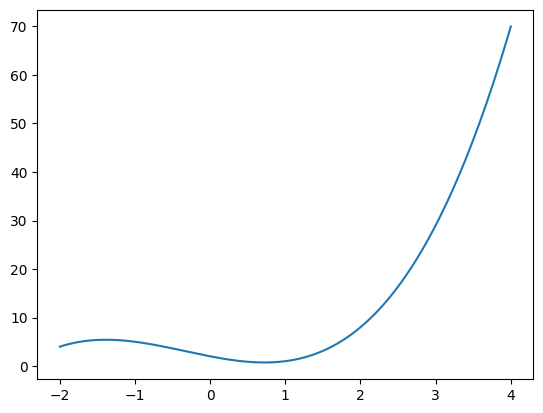

In [6]:
from typing import List, Tuple, Callable, Optional, cast
# Tentar executar localmente a partir da pasta geral do repositório vai dar erro, mas é assim mesmo que deve estar para o deploy.
# Se quiser testar localmente use o comando 'python -m CB2325NumericaG6.polinomios' sem as aspas.
# from .core import RealFunction, Interval, Domain, safe_intersect
from sys import float_info

class Polinomio(RealFunction):
    """
    Representa um polinômio como uma lista de coeficientes, ordenados 
    do termo de **maior grau** para o termo constante.

    P[0] é o coeficiente do maior grau, e o grau é dado por len(P) - 1.
    Exemplo: O polinômio P(x) = 3x^2 + 2x - 1 é representado por [3.0, 2.0, -1.0].
    """

    # Importa o epsilon de maquina do sistema
    BASE_TOLERANCE = float_info.epsilon 

    def __init__(self, values: List[float], domain: Optional[Interval] = None):
        maxAbsCoeff = max((abs(v) for v in values), default=1.0)
        
        # Calcula a tolerância relativa para o polinomio
        self.TOLERANCE = self.BASE_TOLERANCE * maxAbsCoeff

        if self.TOLERANCE == 0.0:
            self.TOLERANCE = self.BASE_TOLERANCE

        self._values = [
            float(v) if abs(v) >= self.TOLERANCE else 0.0
            for v in values
        ]

        if self._values and abs(self._values[0]) < self.TOLERANCE:
            self._clearZeros()

        self.f = lambda x: self.evaluate(x)
        self.domain = domain
        self._primeFunc = None

    def __call__(self, x) -> float:
        return super().__call__(x)
    
    def __repr__(self):
        return str(self._values)
    
    def __len__(self):
        return len(self._values)
    
    def __getitem__(self, index: int):
        size = len(self._values)
        if abs(index) >= size:
            raise IndexError("index out of range")
        elif index < 0:
            return self._values[size + index]
        else:
            return self._values[index]

    def __setitem__(self, index: int, value: float):
        size = len(self._values)
        if abs(index) >= size:
            raise IndexError("assignment index out of range")
        elif index < 0:
            self._values[size + index] = value
        else:
            self._values[index] = value

    def _clearZeros(self):
        """
        Função interna para remover os 0s dos líderes
        """
        count = 0
        for coef in self._values:
            if coef == 0.0:
                count += 1
            else:
                break
        
        if count == len(self._values):
            self._values = []
        elif count> 0:
            self._values = self._values[count:]
        
        if not self._values:
            self._values.append(0.0)

    @property
    def degree(self) -> int:
        return len(self._values)-1
    
    @property
    def isZero(self) -> bool:
        return self._values == [0.0]
    
    @property
    def prime(self): # type: ignore
        if self._primeFunc is None:
            polinomio_derivado = self.diff()
            self._primeFunc = lambda x: polinomio_derivado.evaluate(x) 
        return self._primeFunc
    
    def evaluate(self, x: float) -> float:
        """
            Avalia o polinômio P(x) para um dado valor de x usando o Método de Horner.
            
            P é uma lista de coeficientes em ordem decrescente: [c_n, ..., c_0].
            
            Args:
                x (float): O ponto onde o polinômio será avaliado.
                
            Returns:
                float: O valor P(x).
            
            Examples:
                >>> P = Polinomio([2,3,4])
                >>> val = P.evaluate(1)
                >>> print(val)
                9

        """
        if not self._values:
            return 0.0

        resultado = self._values[0] 
        
        for i in range(1, len(self._values)):
            resultado = resultado * x + self._values[i]
            
        return resultado
    
    def __mul__(self, other: float | int) -> 'Polinomio':
        newValues = [c * float(other) for c in self._values]
        return Polinomio(newValues, self.domain)

    def __rmul__(self, other: float | int) -> 'Polinomio':
        return self.__mul__(other)
    
    def __neg__(self) -> 'Polinomio':
        new_values = [-c for c in self._values]
        return Polinomio(new_values, self.domain)
    
    def __add__(self, other: 'Polinomio') -> 'Polinomio':
        """Adição de polinômios: P1 + P2 (Começando pelo termo de maior grau)"""
        
        newDomain = safe_intersect(self.domain, other.domain)

        p1Coeffs = self._values
        p2Coeffs = other._values

        len1 = len(p1Coeffs)
        len2 = len(p2Coeffs)
        maxLen = max(len1, len2)
        
        newCoeffs = [0.0] * maxLen
        
        for i in range(maxLen):
            idx1 = len1 - 1 - i
            idx2 = len2 - 1 - i
            idx_res = maxLen - 1 - i
            
            c1 = p1Coeffs[idx1] if idx1 >= 0 else 0.0
            c2 = p2Coeffs[idx2] if idx2 >= 0 else 0.0
            
            newCoeffs[idx_res] = c1 + c2
            
        return Polinomio(newCoeffs, newDomain)
    
    def __sub__(self, other: 'Polinomio') -> 'Polinomio':
        negOther = -other 
        return self + negOther
    
    def __eq__(self, other) -> bool:
        #Assume que ambos não tem coeficiente líderes 0.
        if not isinstance(other, Polinomio):
            return NotImplemented
        return other._values == self._values

    def divideBy(self, divisor: 'Polinomio') -> Tuple['Polinomio', 'Polinomio']:
        """
            Realiza a divisão polinomial A / B (self / divisor) e retorna (Quociente, remainder).

            Args:
                divisor (Polinomio): Polinomio divisor
                tolerance (float, optional): Tolerância para checagem de zero, usado para
                    tratar erros de ponto flutuante. O valor padrão é 1e-12.

            Returns:
                Polinomio: Polinomio derivado

            Examples:
                >>> p1 = Polinomio([4,6,8])
                >>> p2 = Polinomio([2,3,4])
                >>> print(p1.divideBy(p2))
                ([2.0], [0.0])
        """

        if divisor.degree < 0 or abs(divisor._values[0]) < self.TOLERANCE:
            raise ValueError("Cannot divide by the zero polynomial.")

        newDomain = safe_intersect(self.domain, divisor.domain)

        if self.degree < divisor.degree:
            return Polinomio([0.0], newDomain), Polinomio(self._values, newDomain)
        
        if divisor.degree == 0:
            constante_divisor = divisor._values[0]
            qCoeffs = [c / constante_divisor for c in self._values]
            return Polinomio(qCoeffs, newDomain), Polinomio([0.0], newDomain)

        mainDivisor = divisor._values[0]
        divisorDegree = divisor.degree
        
        quotientCoeffs = [0.0] * (self.degree - divisorDegree + 1)

        remainder = Polinomio(self._values) 
        
        while remainder.degree >= divisorDegree:
            mainRemainder = remainder._values[0]
            
            degreeDifference = remainder.degree - divisorDegree
            
            qCoeff = mainRemainder / mainDivisor

            qIdx = self.degree - remainder.degree
            quotientCoeffs[qIdx] = qCoeff
    
            multipliedTherm = divisor * qCoeff 

            shiftCoeffs = multipliedTherm._values + [0.0] * degreeDifference
            thermToSub = Polinomio(shiftCoeffs)

            remainder = remainder - thermToSub 

        if remainder.degree < 0:
            remainder = Polinomio([0.0], newDomain)

        return Polinomio(quotientCoeffs, newDomain), remainder
    
    def _getPNeg(self) -> 'Polinomio':
        """
        Cria e retorna o polinômio auxiliar P(-x).
        Isso inverte o sinal dos coeficientes dos termos de grau ímpar.
        """
        PNegCoeffs = []
        
        for i, coeff in enumerate(self._values):
            degree = self.degree - i

            if degree % 2 != 0:
                PNegCoeffs.append(-coeff)
            else:
                PNegCoeffs.append(coeff)
                
        return Polinomio(PNegCoeffs, self.domain)
    
    def getRealRootBounds(self) -> tuple[float, float]:
        """
            Calcula os limites superior positivo (L) e inferior negativo (l) 
            para todas as raízes reais do polinômio P(x)
            (Teorema dos Limites para Raízes de Polinômios (Cauchy Bound)).
        """
        if self.degree == 0:
            return 0.0, 0.0
        
        cn = self._values[0]
        cMax = max(abs(c) for c in self._values[1:]) if self.degree > 0 else 0.0
            
        if cMax == 0.0:
            L = 0.0
        else:
            L = 1.0 + (cMax / abs(cn))

        pNeg = self._getPNeg() 
        
        cnNeg = pNeg._values[0]
        cMaxNeg = max(abs(c) for c in pNeg._values[1:]) if pNeg.degree > 0 else 0.0
        
        if cMaxNeg == 0.0:
            Lneg = 0.0
        else:
            Lneg = 1.0 + (cMaxNeg / abs(cnNeg))

        l = -Lneg
        
        return l, L

    def diff(self) -> 'Polinomio':
        """
            Retorna a derivada de um polinomio.

            Returns:
                Polinomio: Polinomio derivado

            Examples:
                >>> pol = Polinomio([-3.0,2.0,4.0])
                >>> dPol = pol.diff()
                >>> print(dPol)
                [-6.0,2.0]
        """

        if len(self) <= 1:
            return Polinomio([0])
        
        derivative = []

        for i in range(self.degree):
            derivative.append(self[i]*(self.degree-i))

        return Polinomio(derivative, self.domain)

def lambdify(P: 'Polinomio') -> Callable[[float], float]:
    """
    Cria e retorna uma função lambda (Callable) que avalia o polinômio P(x).
    
    Isso permite que o objeto Polinomio seja usado em métodos que esperam 
    uma função f(x), como Bisseção ou Secante.
    
    Args:
        P (Polinomio): O objeto Polinomio a ser convertido.
        
    Returns:
        Callable[[float], float]: Uma função lambda que recebe x (float) 
                                  e retorna P(x) (float).
    """
    
    def func_wrapper(x: float) -> float:
        """Função interna que avalia o polinômio P em x."""
        return P.evaluate(x)
        
    return func_wrapper

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    #Deve ignorar o primeiro coeficiente pois para o epsilon de máquina ele é zero.
    pol = Polinomio([0.0000000000001, 2,5,4,8,5,-3.0,2.0,4000])
    p1 = Polinomio([4,6,8], Interval(1,4))
    p2 = Polinomio([2,3,4], Interval(5,6))

    p3 = p1.divideBy(p2)

    print(p3[0].domain)

    print(p2*2 - p1)
    print(p3)

    print(pol)
    dPol = pol.diff()
    print(dPol)
    print(pol.prime(1))
    print(dPol.domain)

    print(p2.evaluate(1))

    polinomio = Polinomio([1, 1, -3, 2], Interval(-6,6))  # Representa P(x) = x^2 - 3x + 2
    polinomio.plot(Interval(-2, 4), pontos=200)
    plt.show()

## raizes.py

1.4142135620573204


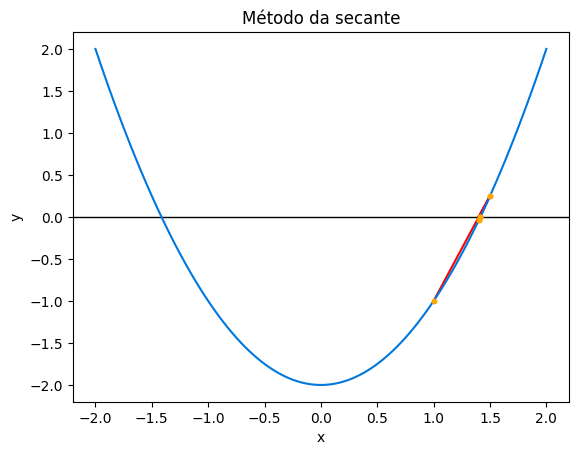

1.4142136573791504


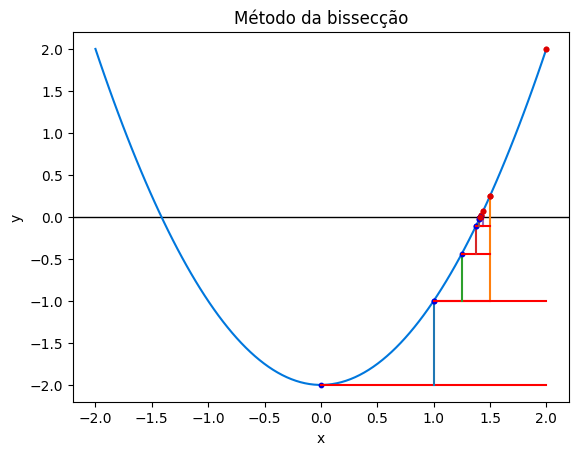

1.4142135857968836


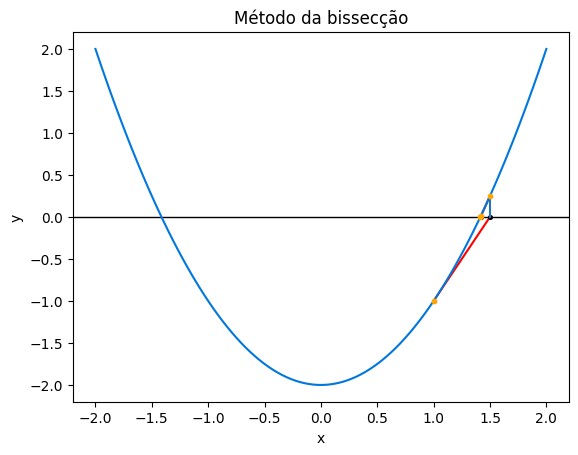

(-3.0, 3.0)
4


In [7]:
# Alunos Responsáveis: Marcelo Alves, Vinícios Flesh

from typing import Callable, List
# Tentar executar localmente a partir da pasta geral do repositório vai dar erro, mas é assim mesmo que o import deve estar para o deploy.
# Se quiser testar localmente use o comando 'python -m CB2325NumericaG6.raizes' sem as aspas.
# from .polinomios import Polinomio # CONSERTAR ERRO!!!
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np


def secante(f: Callable, a: float, b: float, tol: float = 1e-6) -> float:
    """
    Método da secante:
        Consiste em pegar dois pontos próximos a e b e então realiza a apro-
        ximação da raiz a partir do ponto onde a reta que intercepta ambos os
        pontos encontra o eixo X (m), repetindo o processo até que abs(f(m)) 
        seja menor que a tolerância exigida.

    Parametros:
        f: Função a ser analizada
        a: Ponto inicial da função f
        b: Ponto final da função f
        tol: Tolerância para o erro da aproximação final

    Saida:
        Aproximação da raiz da função encontrada.
    """

    a, b = (a, b) if a < b else (b, a)

    interacao = 0
    aproximacao = (f(b) * a - f(a) * b) / (f(b) - f(a))
    while abs(f(aproximacao)) >  tol:
        interacao += 1
        if interacao > 100:
            raise RuntimeError('Método não convergiu')
        a = b
        b = aproximacao
        aproximacao = (f(b) * a - f(a) * b) / (f(b) - f(a))
    return aproximacao
    

def plot_secante(f: Callable, intervalo:tuple[float, float], a: float, b: float, tol: float=1e-6) -> Figure:
    def func_plot() -> None:
        """
        Função auxiliar para visualização gráfica da secante
        """
        aux.scatter([a, b], [f(a), f(b)], s=10, color='orange', zorder=2)
        aux.plot([a, b, aproximacao], [f(a), f(b), 0], color='r', zorder=1)
        aux.scatter(aproximacao, 0, s=7, color='k', zorder=1)
        aux.plot([aproximacao, aproximacao], [f(aproximacao), 0])

    """
    Plotagem do método da secante:
        Consiste em pegar dois pontos próximos a e b e então realiza a apro-
        ximação da raiz a partir do ponto onde a reta que intercepta ambos os
        pontos encontra o eixo X (m), repetindo o processo até que abs(f(m)) 
        seja menor que a tolerância exigida.

    Parametros:
        f: Função a ser analizada
        intervalo: Intervalo da plotagem da função
        a: Ponto inicial da função f
        b: Ponto final da função f
        tol: Tolerância para o erro da aproximação final

    Saida:
        fig: Imagem da plotagem gerada
        Plotagem da representação do processo
    """

    fig, aux = plt.subplots()
    aux.set_xlabel('x')
    aux.set_ylabel('y')
    aux.set_title('Método da secante')
    aux.axhline(0, color='k', lw=1)

    x = np.linspace(intervalo[0], intervalo[1], 100)
    aux.plot(x, f(x), color='#07d')

    a, b = (a, b) if a < b else (b, a)

    interacao = 0
    aproximacao = (f(b) * a - f(a) * b) / (f(b) - f(a))
    func_plot()
    while abs(f(aproximacao)) >  tol:
        interacao += 1
        if interacao > 100:
            raise RuntimeError('Método não convergiu')
        a = b
        b = aproximacao
        aproximacao = (f(b) * a - f(a) * b) / (f(b) - f(a))
        if aproximacao < min(intervalo) or aproximacao > max(intervalo):
            raise ValueError(f'Aproximação fora do intervalo [{min(intervalo)}, {max(intervalo)}]')
        func_plot()


    plt.show()
    return fig


def bisseccao(f: Callable, a: float, b: float, tol: float=1e-6) -> float:
    """
    Método da bissecção:
        Consiste em pegar um intervalo a e b na qual f(a) tem sinal oposto a f(b),
        então realiza a aproximação da raiz a partir de média do intervalo (m), 
        repetindo o processo até que abs(f(m)) seja menor que a tolerância exigida.

    Parametros:
        f: Função a ser analizada
        a: Intervalo inicial da função f
        b: Intervalo final da função f
        tol: Tolerancia para o erro da aproximação final

    Saida:
        Aproximação da raiz da função no intervalo [a, b]
    """

    if f(a) * f(b) > 0:
        raise ValueError('f(a) tem o mesmo sinal que f(b), não há garantia da existencia de uma raiz')
    
    a, b = (a, b) if f(a) < f(b) else (b, a)

    aproximacao = (a + b) / 2
    while abs(f(aproximacao)) > tol:
        if f(aproximacao) > 0:
            b = aproximacao
        else:
            a = aproximacao
        
        aproximacao = (a + b) / 2

    return aproximacao


def plot_bisseccao(f: Callable, intervalo:tuple[float, float], a:float, b:float, tol: float = 1e-6) -> Figure:
    def func_plot():
        """Função auxiliar para o método da bissecção"""
        aux.scatter(a, f(a), s=10, color='#00D', zorder=2)
        aux.scatter(b, f(b), s=10, color='#D00', zorder=2)
        aux.plot([a, b], [f(a), f(a)], color='r')
        aux.plot([aproximacao, aproximacao], [f(a), f(aproximacao)])

    """
    Plotagem método da bissecção:
        Consiste em pegar um intervalo a e b na qual f(a) tem sinal oposto a f(b),
        então realiza a aproximação da raiz a partir de média do intervalo (m), 
        repetindo o processo até que abs(f(m)) seja menor que a tolerância exigida.

    Parametros:
        f: Função a ser analizada
        intervalo: Intervalor de plotagem
        a: Ponto inicial da função f
        b: Ponto final da função f
        tol: Tolerancia para o erro da aproximação final

    Saida:
        fig: Imagem do processo de bissecção
        Plotagem do processo de bissecção
    """

    if f(a) * f(b) > 0:
        raise ValueError('f(a) tem o mesmo sinal que f(b), não há garantia da existencia de uma raiz')

    fig, aux = plt.subplots()
    aux.set_xlabel('x')
    aux.set_ylabel('y')
    aux.set_title('Método da bissecção')
    aux.axhline(0, color='k', lw=1)

    x = np.linspace(intervalo[0], intervalo[1], 100)
    aux.plot(x, f(x), color='#07d')

    a, b = (a, b) if f(a) < f(b) else (b, a)

    aproximacao = (a + b) / 2
    func_plot()
    while abs(f(aproximacao)) > tol:
        if f(aproximacao) > 0:
            b = aproximacao
        else:
            a = aproximacao
        
        aproximacao = (a + b) / 2
        func_plot()

    plt.show()
    return fig


def newton_raphson(f: Callable, df: Callable, a:float, tol: float= 1e-6) -> float:
    """
    Método de Newton Raphson:
        Consiste em pegar um ponto a e então realiza a aproximação da raiz a
        partir do ponto onde a reta tangente o ponto a encontra o eixo X (m),
        repetindo o processo até que abs(f(m)) seja menor que a tolerância 
        exigida.

    Parametros:
        f: Função a ser analizada
        df: Derivada de f
        a: Ponto inicial da função f
        tol: Tolerancia para o erro da aproximação final

    Saida:
        Aproximação da raiz da função encontrada.
    """
    
    interacao = 0
    aproximacao = a - f(a)/df(a)
    while abs(f(aproximacao)) > tol:
        interacao += 1
        if interacao > 100:
            raise RuntimeError('Método não convergiu')
        a = aproximacao
        aproximacao = a - f(a)/df(a)
    
    return aproximacao


def plot_newton_raphson(f: Callable, intervalo:tuple[float, float], df: Callable, a:float, tol: float = 1e-6) -> Figure:
    def func_plot():
        """
        Função auxiliar para plotagem do método de newton-raphson
        """
        aux.scatter(a, f(a), s=10, color='orange', zorder=2)
        aux.plot([a, aproximacao], [f(a), 0], color='r', zorder=1)
        aux.scatter(aproximacao, 0, s=7, color='k', zorder=1)
        aux.plot([aproximacao, aproximacao], [f(aproximacao), 0])

    """
    Plotagem do método de Newton Raphson:
        Consiste em pegar um ponto a e então realiza a aproximação da raiz a
        partir do ponto onde a reta tangente o ponto a encontra o eixo X (m),
        repetindo o processo até que abs(f(m)) seja menor que a tolerância 
        exigida.

    Parametros:
        f: Função a ser analizada
        intervalo: Intervalo da plotagem
        df: Derivada de f
        a: Ponto inicial da função f
        tol: Tolerancia para o erro da aproximação final

    Saida:
        fig: Imagem gerada pelo método de newton-raphson
        plotagem do método de newton-raphson 
    """

    fig, aux = plt.subplots()
    aux.set_xlabel('x')
    aux.set_ylabel('y')
    aux.set_title('Método da bissecção')
    aux.axhline(0, color='k', lw=1)

    x = np.linspace(intervalo[0], intervalo[1], 100)
    aux.plot(x, f(x), color='#07d')

    interacao = 0
    aproximacao = a - f(a)/df(a)
    func_plot()
    while abs(f(aproximacao)) > tol:
        interacao += 1
        if interacao > 100:
            raise RuntimeError('Método não convergiu')
        a = aproximacao
        aproximacao = a - f(a)/df(a)

        if aproximacao < min(intervalo) or aproximacao > max(intervalo):
            raise ValueError(f'Aproximação fora do intervalo [{min(intervalo)}, {max(intervalo)}]')
        func_plot()

    plt.show()
    return fig


def _sturmSequence(P: Polinomio) -> List[Polinomio]:
    sequence = [P, P.diff()]
    remainder = sequence[1]
    index = 1
    while True:
        _, remainder = sequence[index-1].divideBy(sequence[index])
        if remainder.isZero:
            break

        sequence.append(-remainder)
        index += 1

    return sequence


def _countSignVariations(sequence: List[Polinomio], x):
    # TODO: Talvez substituir tolerância por algum calculo de erro no futuro quando .erros.py for implementado
    tolerance = 1e-15

    changes = 0
    signs = []
    for p in sequence:
        value = p.evaluate(x)
        if abs(value) < tolerance:
            continue

        if value > 0:
            signs.append(True)
        else:
            signs.append(False)

    if len(signs) < 2:
        return 0
    
    last = signs[0]
    for i in range(1, len(signs)):
        if signs[i] != last:
            last = signs[i]
            changes += 1

    return changes


def sturm(P: Polinomio, a: float, b: float) -> int:
    """
        Calcula o número de raízes reais de um polinomio no intervalo (a,b].

        Args:
            P (Polinomio): Polinomio a ser avaliado.
            a (float): Extremo inferior do intervalo.
            b (flaot): Extremo superior do intervalo.
        
        Returns:
            int: Número de raízes reais no intervalo (a,b]
        
        Raises:
            ValueError: Limite inferior a é maior ou igual que limite superior b
        
        Examples:
            >>> P = Polinomio([1.0,-2.0,-2.0,2.0, 0])
            >>> raizes = sturm(P, -2, 3)
            >>> print(raizes)

    """
    if a >= b:
        raise ValueError("O limite inferior 'a' deve ser menor que o limite superior 'b'.")

    sequence = _sturmSequence(P)

    signsA = _countSignVariations(sequence, a)
    signsB = _countSignVariations(sequence, b)

    return signsA - signsB


if __name__ == '__main__':
    f = lambda x: x**2 - 2
    df = lambda x: 2*x

    print(secante(f, 1, 1.5, 1e-6))
    plot_secante(f, (-2, 2), 1, 1.5, 1e-6)

    print(bisseccao(f, 0, 2, 1e-6))
    plot_bisseccao(f, (-2, 2), 0, 2, 1e-6)

    print(newton_raphson(f, df, 5, 10 **-6))
    plot_newton_raphson(f, (-2, 2), df, 1, 1e-6)


    P = Polinomio([1.0,-2.0,-2.0,2.0, 0])
    bounds = P.getRealRootBounds()
    print(bounds)
    raizes = sturm(P, bounds[0], bounds[1])
    print(raizes)

In [8]:
from numpy import cos, sin, e, pi, log

---

## Exemplo 1:

$$ f(x) = 3x+1 $$
$$ x \in [-2,2] \Rightarrow x = -\frac{1}{3} \approx -0.333333... $$

In [10]:
f = lambda x: 3*x + 1
df = lambda x: 3
raiz = 1/3

resultado_bissecao = bisseccao(f, -2, 2, 1e-6)
resultado_secante = secante(f, -2, 2, 1e-6)
resultado_newton = newton_raphson(f, df, 2, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |     -0.33333301544189453     |      0.6666663487752278      |
---------------------------------------------------------------------------------------------------
|              Secante              |     -0.3333333333333333      |      0.6666666666666666      |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |     -0.3333333333333335      |      0.6666666666666667      |
---------------------------------------------------------------------------------------------------


---

## Exemplo 2:

$$ f(x) = x^2 - 16 $$
$$ x \in [3,5] \Rightarrow x = 4 $$

In [12]:
f = lambda x: x**2 - 16
df = lambda x: 2 * x
raiz = 4

resultado_bissecao = bisseccao(f, 3, 5, 1e-6)
resultado_secante = secante(f, 3, 5, 1e-6)
resultado_newton = newton_raphson(f, df, 5, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |             4.0              |             0.0              |
---------------------------------------------------------------------------------------------------
|              Secante              |      3.9999999999889426      |    1.1057377236056709e-11    |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |      4.000000000000004       |    4.440892098500626e-15     |
---------------------------------------------------------------------------------------------------


---

## Exemplo 3:

$$ f(x) = x^2 - 5 $$

$$ x \in [2,3] \Rightarrow x = \sqrt{5} \approx 2.236067977... $$

In [14]:
f = lambda x: x**2 - 5
df = lambda x: 2 * x
raiz = 5**0.5

resultado_bissecao = bisseccao(f, 2, 3, 1e-6)
resultado_secante = secante(f, 2, 3, 1e-6)
resultado_newton = newton_raphson(f, df, 3, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |      2.236067771911621       |    2.0558816871130148e-07    |
---------------------------------------------------------------------------------------------------
|              Secante              |      2.236067926333413       |    5.116637691315873e-08     |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |      2.236067977499978       |    1.8829382497642655e-13    |
---------------------------------------------------------------------------------------------------


---

## Exemplo 4

$$ f(x) = x^3 - 7 $$
$$ x \in [1,2] \Rightarrow x = \sqrt[3]{7} \approx 1.912931182... $$

In [16]:
f = lambda x: x**3 - 7
df = lambda x: 3*x**2
raiz = 7**(1/3)

resultado_bissecao = bisseccao(f, 1, 2, 1e-6)
resultado_secante = secante(f, 1, 2, 1e-6)
resultado_newton = newton_raphson(f, df, 2, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |      1.912931203842163       |    2.106977414761957e-08     |
---------------------------------------------------------------------------------------------------
|              Secante              |      1.912931182768554       |    3.834932371660216e-12     |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |      1.9129311828000604      |    2.7671420710362327e-11    |
---------------------------------------------------------------------------------------------------


---

## Exemplo 5:

$$ f(x) = \cos(x) - \sin(x) $$
$$ x \in [0,1] \Rightarrow x = \frac{\pi}{4} \approx 0.785398163... $$

In [18]:
f = lambda x: cos(x) - sin(x)
df = lambda x: -sin(x) - cos(x)
raiz = pi/4

resultado_bissecao = bisseccao(f, 0, 1, 1e-6)
resultado_secante = secante(f, 0, 1, 1e-6)
resultado_newton = newton_raphson(f, df, 1, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |      0.7853984832763672      |    3.198789189085005e-07     |
---------------------------------------------------------------------------------------------------
|              Secante              |      0.7853981577626146      |    5.634833710743692e-09     |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |      0.7853981759997019      |    1.2602253574023337e-08    |
---------------------------------------------------------------------------------------------------


---

## Exemplo 6:

$$ f(x) = e^x-3 $$
$$ x \in [1,2] \Rightarrow x = \ln(3) \approx 1.098612288... $$

In [19]:
f = lambda x: e**x - 3
df = lambda x: e**x
raiz = log(3)

resultado_bissecao = bisseccao(f, 1, 2, 1e-6)
resultado_secante = secante(f, 1, 2, 1e-6)
resultado_newton = newton_raphson(f, df, 2, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |      1.0986123085021973      |    1.9834087483516782e-08    |
---------------------------------------------------------------------------------------------------
|              Secante              |      1.098612288366849       |    3.0126079408887563e-10    |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |      1.0986122886681922      |    8.237854842718662e-14     |
---------------------------------------------------------------------------------------------------


---